# xgboost model

## IMPORTS

In [6]:
!pip install xgboost


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00


In [195]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import linregress

## Load your data

In [196]:
df = pd.read_csv('../raw_data/all_clean_weather_1984_2024_filtered.csv', parse_dates=['DATE'])

In [197]:
df.head()

,NOM_USUEL,LAT,LON,DATE,RR,TN,TX,TM,FFM,DEP,Co2 Mole fraction (ppm),Methane ppm
0,ROMORANTIN,47.319667,1.6875,1984-01-01,0.0,2.1,5.4,3.4,2.8,41,"344,07","1,64468"
1,ROMORANTIN,47.319667,1.6875,1984-01-02,3.8,4.2,7.5,5.9,5.3,41,"344,07","1,64468"
2,ROMORANTIN,47.319667,1.6875,1984-01-03,8.6,5.0,9.2,6.7,8.1,41,"344,07","1,64468"
3,ROMORANTIN,47.319667,1.6875,1984-01-04,0.1,0.5,6.9,3.4,3.6,41,"344,07","1,64468"
4,ROMORANTIN,47.319667,1.6875,1984-01-05,2.9,-3.4,6.8,1.8,2.8,41,"344,07","1,64468"


In [198]:
print(df.columns)

Index(['NOM_USUEL', 'LAT', 'LON', 'DATE', 'RR', 'TN', 'TX', 'TM', 'FFM', 'DEP',
       'Co2 Mole fraction (ppm)', 'Methane ppm'],
      dtype='object')


## Feature Engineering

In [199]:
df.rename(columns={
    'TX': 'max_temperature',
    'TM': 'avg_temperature',
    'TN': 'min_temperature',
    'NOM_USUEL': 'location',
    'LAT': 'lat',
    'LON': 'lon',
    'DATE': 'DATE',
    'RR': 'amount_precipitation',
    'Co2 Mole fraction (ppm)': 'co2',
    'Methane ppm': 'ch4'
}, inplace=True)

# First replace ',' by '.' then convert to float
df['co2'] = df['co2'].str.replace(',', '.').astype(float)
df['ch4'] = df['ch4'].str.replace(',', '.').astype(float)

df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

In [200]:
df.head()

,location,lat,lon,DATE,amount_precipitation,min_temperature,max_temperature,avg_temperature,FFM,DEP,co2,ch4,year,month
0,ROMORANTIN,47.319667,1.6875,1984-01-01,0.0,2.1,5.4,3.4,2.8,41,344.07,1.64468,1984,1
1,ROMORANTIN,47.319667,1.6875,1984-01-02,3.8,4.2,7.5,5.9,5.3,41,344.07,1.64468,1984,1
2,ROMORANTIN,47.319667,1.6875,1984-01-03,8.6,5.0,9.2,6.7,8.1,41,344.07,1.64468,1984,1
3,ROMORANTIN,47.319667,1.6875,1984-01-04,0.1,0.5,6.9,3.4,3.6,41,344.07,1.64468,1984,1
4,ROMORANTIN,47.319667,1.6875,1984-01-05,2.9,-3.4,6.8,1.8,2.8,41,344.07,1.64468,1984,1


## Define Features (X) and Target (y)

In [201]:

monthly_df = df.groupby(['location', 'year', 'month']).agg({
    'avg_temperature': 'mean',
    'lat': 'first',
    'lon': 'first',
    'amount_precipitation': 'mean',
    'co2': 'mean',
    'ch4': 'mean'
}).reset_index()

monthly_df['years_since_1984'] = monthly_df['year'] - 1984
monthly_df['year_month'] = pd.to_datetime(monthly_df['year'].astype(str) + '-' + monthly_df['month'].astype(str) + '-01')

# Features to use
features = ['lat', 'lon', 'years_since_1984', 'month', 'amount_precipitation', 'co2', 'ch4']
X = monthly_df[features]
y = monthly_df['avg_temperature']

## Train/Test Split

In [202]:
cutoff_year = 2021
X_train = X[monthly_df['year'] < cutoff_year]
y_train = y[monthly_df['year'] < cutoff_year]
X_test = X[monthly_df['year'] >= cutoff_year]
y_test = y[monthly_df['year'] >= cutoff_year]

## Train the XGBoost model

In [218]:
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

## Evaluate

In [219]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

MAE: 1.303
RMSE: 1.634


## Plot true vs predicted

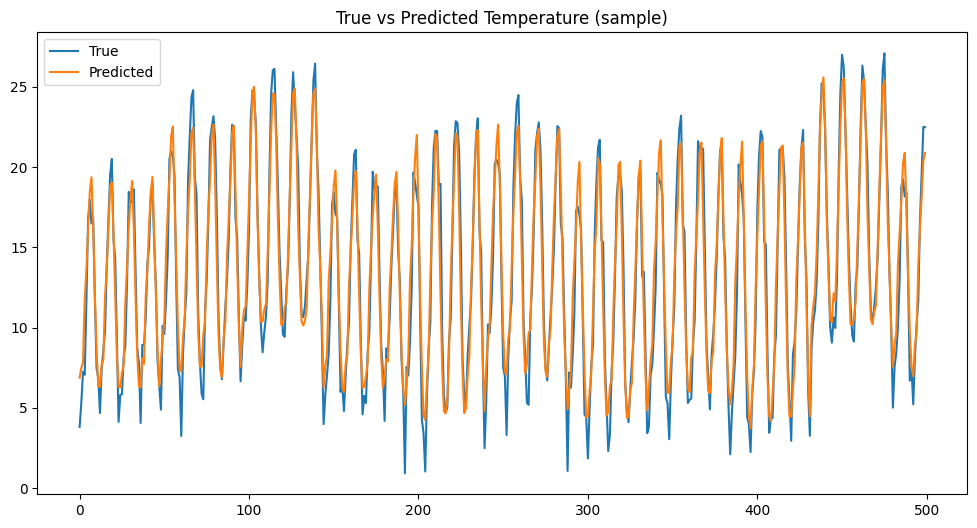

In [220]:
# 7. Optional: Plot true vs predicted
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:500], label='True')
plt.plot(y_pred[:500], label='Predicted')
plt.legend()
plt.title('True vs Predicted Temperature (sample)')
plt.show()

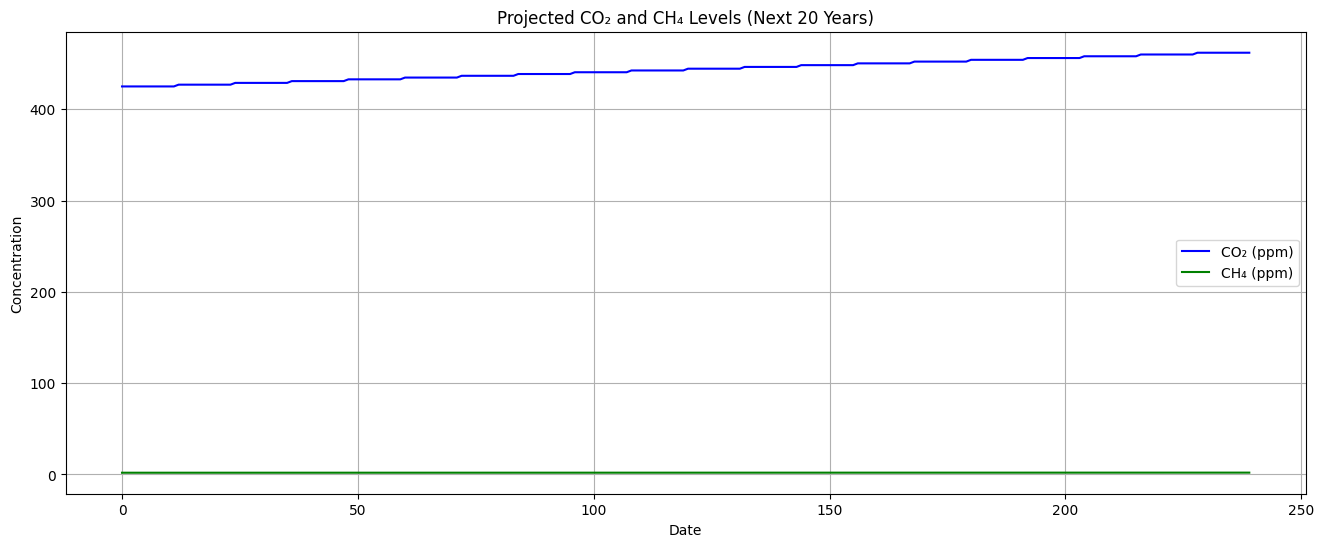

In [221]:
# Plot future CO2 and CH4 over time
plt.figure(figsize=(16,6))

# Plot CO2
plt.plot(future_input_df.index, future_input_df['co2'], label='CO₂ (ppm)', color='blue')

# Plot CH4
plt.plot(future_input_df.index, future_input_df['ch4'], label='CH₄ (ppm)', color='green')

plt.title(f"Projected CO₂ and CH₄ Levels (Next 20 Years)")
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

In [222]:
from scipy.stats import linregress

# Group by year
annual_means = df.groupby('year').agg({
    'co2': 'mean',
    'ch4': 'mean'
}).reset_index()

# Calculate the slope (increase per year) using linear regression
co2_slope, co2_intercept, _, _, _ = linregress(annual_means['year'], annual_means['co2'])
ch4_slope, ch4_intercept, _, _, _ = linregress(annual_means['year'], annual_means['ch4'])

print(f"Average CO₂ increase per year: {co2_slope:.4f} ppm/year")
print(f"Average CH₄ increase per year: {ch4_slope:.6f} ppm/year")

Average CO₂ increase per year: 1.9441 ppm/year
Average CH₄ increase per year: 0.005699 ppm/year


## Save the model if you want

In [223]:
#model.save_model('xgboost_temp_predictor.json')

## PREDICT

In [224]:
def build_future_monthly_dataframe(lat_value, lon_value, start_year, n_years, co2_start, ch4_start, co2_slope, ch4_slope):
    data = {
        'lat': [],
        'lon': [],
        'year': [],
        'month': [],
        'amount_precipitation': [],
        'co2': [],
        'ch4': []
    }
    
    for year in range(start_year, start_year + n_years):
        for month in range(1, 13):
            years_ahead = year - 2024
            est_co2 = co2_start + years_ahead * co2_slope
            est_ch4 = ch4_start + years_ahead * ch4_slope

            data['lat'].append(lat_value)
            data['lon'].append(lon_value)
            data['year'].append(year)
            data['month'].append(month)
            data['amount_precipitation'].append(0.0)
            data['co2'].append(est_co2)
            data['ch4'].append(est_ch4)
    
    return pd.DataFrame(data)

In [225]:
# Choose location
chosen_location = 'AJACCIO'  # <-- Change as needed
lat_value = df[df['location'] == chosen_location]['lat'].iloc[0]
lon_value = df[df['location'] == chosen_location]['lon'].iloc[0]

# Last known CO2/CH4 from 2024
co2_2024 = df[df['year'] == 2024]['co2'].mean()
ch4_2024 = df[df['year'] == 2024]['ch4'].mean()

# Build future input
future_input_df = build_future_monthly_dataframe(
    lat_value, lon_value,
    start_year=datetime.date.today().year,
    n_years=20,
    co2_start=co2_2024,
    ch4_start=ch4_2024,
    co2_slope=co2_slope,
    ch4_slope=ch4_slope
)

# Add year_month and years_since_1984 columns
future_input_df['year_month'] = pd.to_datetime(
    future_input_df['year'].astype(str) + '-' + future_input_df['month'].astype(str) + '-01'
)
future_input_df['years_since_1984'] = future_input_df['year'] - 1984

# Predict future
future_predictions = model.predict(future_input_df[features])

In [226]:
# Create year_month date column if not done
future_input_df['year_month'] = pd.to_datetime(
    future_input_df['year'].astype(str) + '-' + future_input_df['month'].astype(str) + '-01'
)

# Build a predictions DataFrame
pred_df = pd.DataFrame({
    'date': future_input_df['year_month'],
    'predicted_temperature': future_predictions
})

In [227]:
print(pred_df.head())

        date  predicted_temperature
0 2025-01-01              10.738039
1 2025-02-01              11.880003
2 2025-03-01              11.990206
3 2025-04-01              15.347558
4 2025-05-01              18.726248


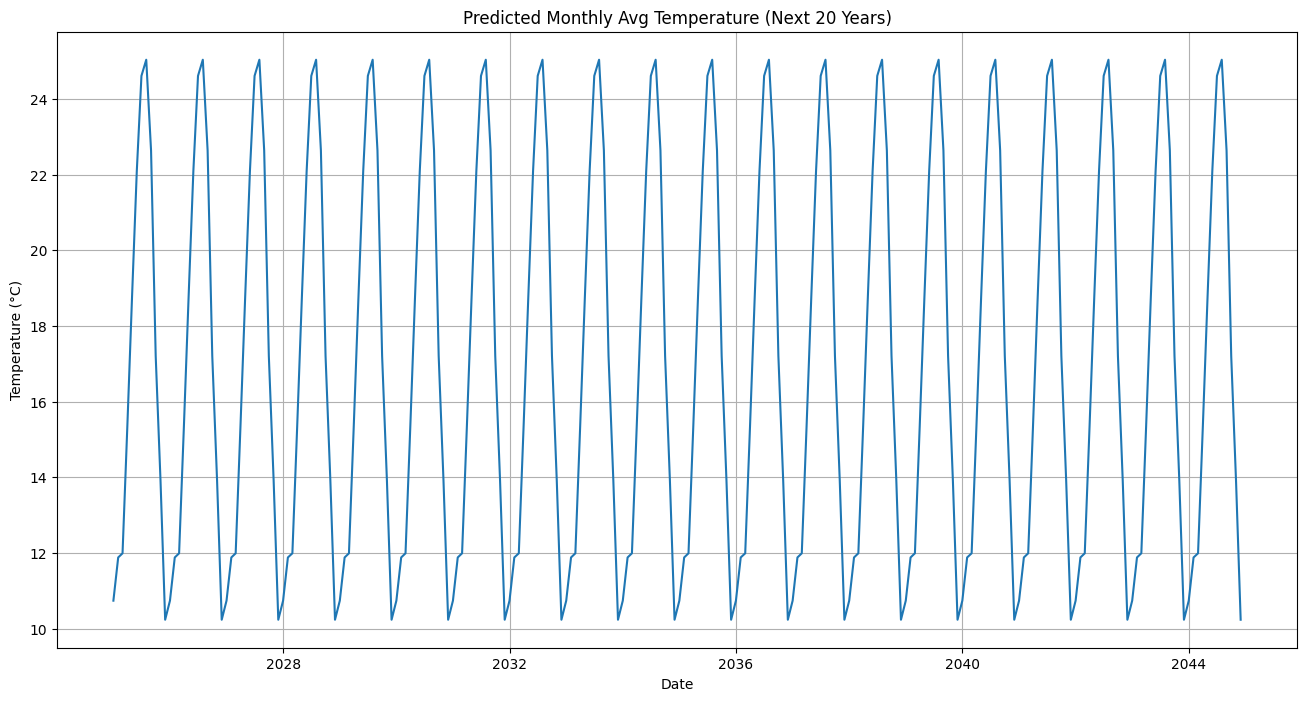

In [228]:
plt.figure(figsize=(16,8))
plt.plot(pred_df['date'], pred_df['predicted_temperature'])
plt.title("Predicted Monthly Avg Temperature (Next 20 Years)")
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

In [229]:
def predict_temperature(location_name, future_date, df, model, features, co2_slope, ch4_slope, co2_2024, ch4_2024):
    # Extract location lat/lon
    lat_value = df[df['location'] == location_name]['lat'].iloc[0]
    lon_value = df[df['location'] == location_name]['lon'].iloc[0]
    
    # Calculate years since 1984
    years_since_1984 = future_date.year - 1984
    
    # Estimate CO2 and CH4 based on growth rates
    years_after_2024 = future_date.year - 2024
    estimated_co2 = co2_2024 + years_after_2024 * co2_slope
    estimated_ch4 = ch4_2024 + years_after_2024 * ch4_slope

    # Build a single-row input DataFrame
    input_data = pd.DataFrame([{
        'lat': lat_value,
        'lon': lon_value,
        'years_since_1984': years_since_1984,
        'month': future_date.month,
        'amount_precipitation': 0.0,  # Assume 0 for now
        'co2': estimated_co2,
        'ch4': estimated_ch4
    }])

    # Predict
    prediction = model.predict(input_data[features])[0]
    return prediction

In [232]:
def predict_future_trend(location_name, df, model, features, co2_slope, ch4_slope, co2_2024, ch4_2024, years_ahead=20):
    # Extract lat/lon
    lat_value = df[df['location'] == location_name]['lat'].iloc[0]
    lon_value = df[df['location'] == location_name]['lon'].iloc[0]

    # Build future dates (month by month)
    today_year = datetime.date.today().year
    future_years = range(today_year, today_year + years_ahead)

    future_data = {
        'lat': [],
        'lon': [],
        'year': [],
        'month': [],
        'amount_precipitation': [],
        'co2': [],
        'ch4': [],
        'years_since_1984': []
    }
    
    for year in future_years:
        for month in range(1, 13):
            years_since_1984 = year - 1984
            years_after_2024 = year - 2024
            est_co2 = co2_2024 + years_after_2024 * co2_slope
            est_ch4 = ch4_2024 + years_after_2024 * ch4_slope

            future_data['lat'].append(lat_value)
            future_data['lon'].append(lon_value)
            future_data['year'].append(year)
            future_data['month'].append(month)
            future_data['amount_precipitation'].append(0.0)
            future_data['co2'].append(est_co2)
            future_data['ch4'].append(est_ch4)
            future_data['years_since_1984'].append(years_since_1984)

    future_df = pd.DataFrame(future_data)

    # Predict future monthly temperatures
    monthly_preds = model.predict(future_df[features])

    # Build DataFrame
    future_df['predicted_temperature'] = monthly_preds
    future_df['year_month'] = pd.to_datetime(
        future_df['year'].astype(str) + '-' + future_df['month'].astype(str) + '-01'
    )

    # Aggregate to annual average temperature
    annual_trend = future_df.groupby('year')['predicted_temperature'].mean().reset_index()

    return future_df, annual_trend

In [233]:
future_monthly_df, annual_trend_df = predict_future_trend(
    location_name='AJACCIO',
    df=df,
    model=model,
    features=features,
    co2_slope=co2_slope,
    ch4_slope=ch4_slope,
    co2_2024=co2_2024,
    ch4_2024=ch4_2024,
    years_ahead=20
)

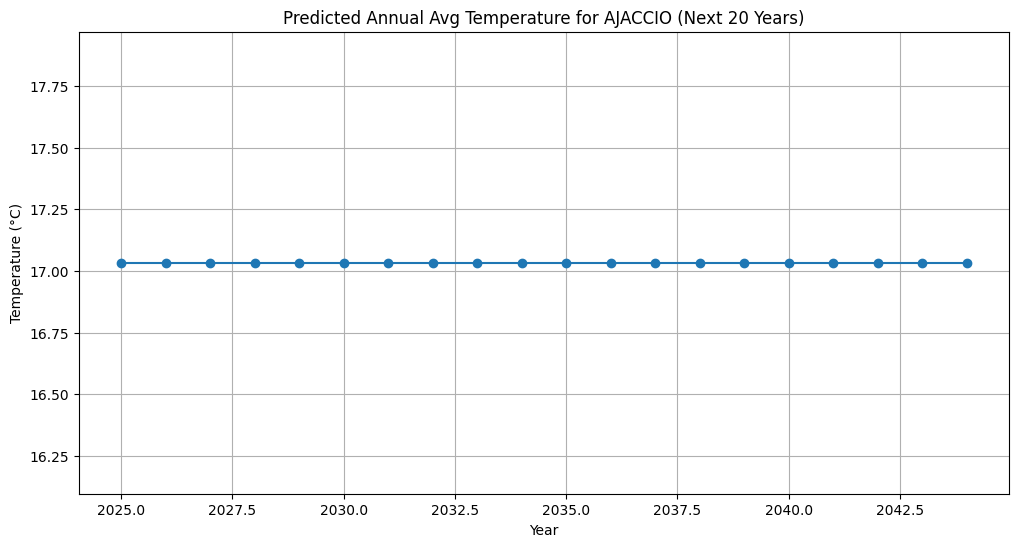

In [234]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(annual_trend_df['year'], annual_trend_df['predicted_temperature'], marker='o')
plt.title(f"Predicted Annual Avg Temperature for AJACCIO (Next 20 Years)")
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

In [230]:
import datetime

# Choose a future date
future_date = datetime.date(2045, 4, 7)
location = 'AJACCIO'  # Your station name

# Then predict
predicted_temp = predict_temperature(
    location_name=location,
    future_date=future_date,
    df=df,
    model=model,
    features=features,
    co2_slope=co2_slope,
    ch4_slope=ch4_slope,
    co2_2024=co2_2024,
    ch4_2024=ch4_2024
)

print(f"Predicted avg temperature for {location} on {future_date}: {predicted_temp:.2f}°C")

Predicted avg temperature for AJACCIO on 2045-04-07: 15.35°C


In [121]:
first_10_locations = df['location'].unique()[:10]
print(first_10_locations)

['ROMORANTIN' 'BISCARROSSE' 'DAX' 'MONT-DE-MARSAN' 'ST GIRONS'
 'METZ-FRESCATY' 'BELLE ILE-LE TALUT' 'LORIENT-LANN BIHOUE' 'AJACCIO'
 'CAP PERTUSATO']
